In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime

import matplotlib.pyplot as plt
#import cartopy
import cartopy.crs
#crs = cartopy.crs.PlateCarree()
#import cartopy.feature as cfeature

import pyinterp

import swot_calval.io
import swot_calval.statistics
import swot_calval.tests

import sys
sys.path.append("/work/HELPDESK_SWOTLR/swot_diego/libs")
import swot_diego as sd

In [3]:
client, cluster = sd.spin_up_cluster(jobs=4, memory='16GiB', walltime='04:00:00')
#cores=1,
#memory='8GiB', # Balanced configuration should have 8 GiB per core if possible
#cluster.scale(jobs=4)

In [4]:
cluster

Dashboard: /user/pontea/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.11.2.129:39255,Workers: 0
Dashboard: /user/pontea/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---

## common and utils

In [ ]:
#region = "med_NW_CN"
region = "med_NW"
#region = "maluku"
info = sd.regions[region]
extent = info["extent"]
extent[1] = 6.2

# define bins for diagnostics
dl=.05
ext = ( 
    np.floor(info["extent"][0]/dl)*dl, 
    np.ceil(info["extent"][1]/dl)*dl,
    np.floor(info["extent"][2]/dl)*dl, 
    np.ceil(info["extent"][3]/dl)*dl,
)
lon_bins = np.arange(ext[0], ext[1], dl)
lat_bins = np.arange(ext[2], ext[3], dl)

In [ ]:
def gather_stats(da, lon_bins, lat_bins, label=None):

    binning = pyinterp.Binning2D(
        pyinterp.Axis(lon_bins),
        pyinterp.Axis(lat_bins),
    )
        
    binning.clear()
    binning.push(da.longitude, da.latitude, da, True)    
    
    if label is None:
        label = da.name

    dims = ("longitude", "latitude")
    ds = xr.Dataset(
        {label+"_"+diag: (dims, binning.variable(diag)) for diag in ["count", "mean", "variance",]},
        coords = dict(longitude=lon_bins, latitude=lat_bins)
    ).transpose("latitude", "longitude")
    
    return ds

#            * ``count`` : compute the count of points within each bin.
#            * ``kurtosis`` : compute the kurtosis of values for points
#              within each bin.
#            * ``max`` : compute the maximum of values for point within
#              each bin.
#            * ``mean`` : compute the mean of values for points within
#              each bin.
#            * ``min`` : compute the minimum of values for points within
#              each bin.
#            * ``skewness`` : compute the skewness within each bin.
#            * ``sum`` : compute the sum of values for points within
#              each bin.
#            * ``sum_of_weights`` : compute the sum of weights within
#              each bin.
#            * ``variance`` : compute the variance within each bin.        

---

## L3

In [49]:
# selected variables
l3_variables = sd.l3["ssh"] #+sd.l3["speed"]+sd.l3["sig0"]

ds = sd.load_l3(
    pass_numbers=info["passes"],
    variables=l3_variables,
    first_day=datetime.date(2023, 4, 1),
    last_day=datetime.date(2023, 7, 15),
    geoselection=info['coordinates'],
    half_orbits=False,
)
#return_collection=True)

SyntaxError: invalid syntax (3638908758.py, line 6)

In [6]:
ds = ds.to_xarray().persist()

In [91]:
# dev
#da = ds["ssha_karin_2_filtered"].where( ds["ssha_karin_2_qual"]<mask_level )
#diag = gather_stats(da, lon_bins, lat_bins, binning, label="ssha")
#fig, ax = sd.plot_map(info["extent"], figsize=(5,5))
#h = diag["ssha_mean"].plot(ax=ax, transform=sd.crs)
#fig.colorbar(h, orientation='horizontal')

In [9]:
variables = sd.l3["ssh"]
labels = dict(ssha_karin_2_filtered="ssha")

mask_level = 1
mask = ds["ssha_karin_2_qual"]

diags = xr.merge(
    [
        gather_stats(
            ds[key].where(mask<mask_level), 
            lon_bins, lat_bins, 
            #label=labels.get(key),
        )
        for key in variables
    ]
)

#add std
for v in variables:
    diags[v+"_std"] = np.sqrt(diags[v+"_variance"])

<Axes: >

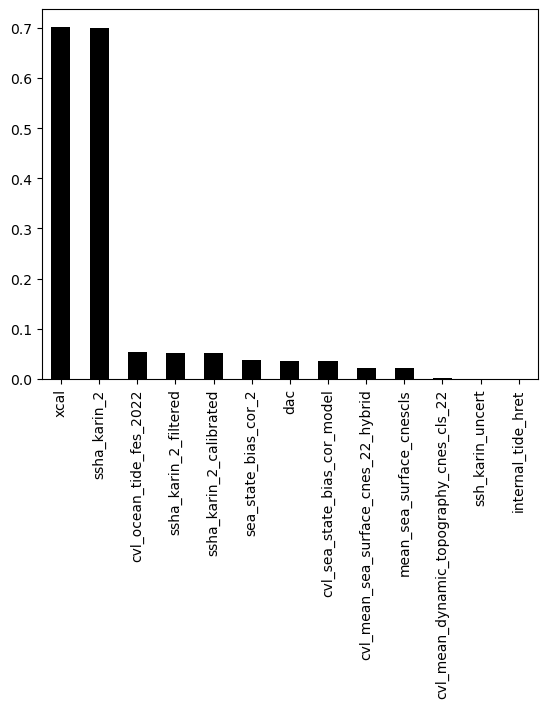

In [58]:
# gather median of diags and plot
diags_median = diags.median()

Dm, Dv = [], []
idx = []
for v in variables:
    if any([e in v for e in exclude]):
        continue
    Dm.append(float(diags_median[v+"_mean"]))
    Dv.append(float(diags_median[v+"_variance"]))
    idx.append(v)
    
df = pd.DataFrame(dict(mean=Dm, variance=Dv), index=idx)
df = df.sort_values("variance", ascending=False)
df["std"] = np.sqrt(df["variance"])

df["std"].plot.bar(rot=90, color="k")

<Axes: >

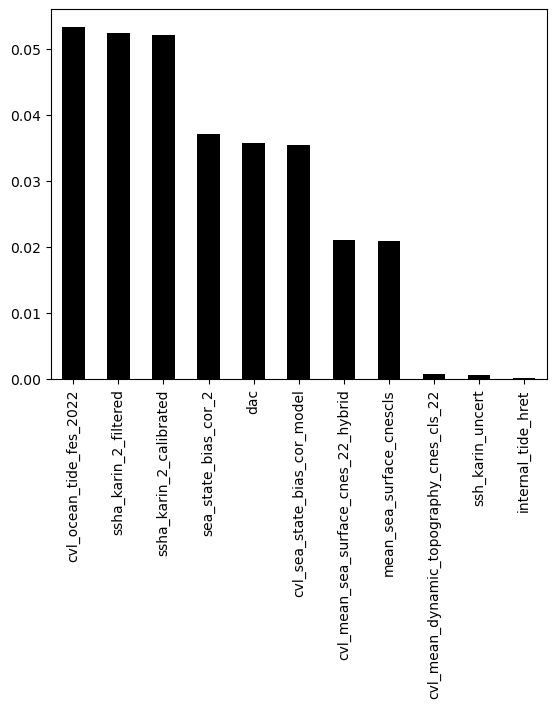

In [59]:
df["std"].iloc[2:].plot.bar(rot=90, color="k")

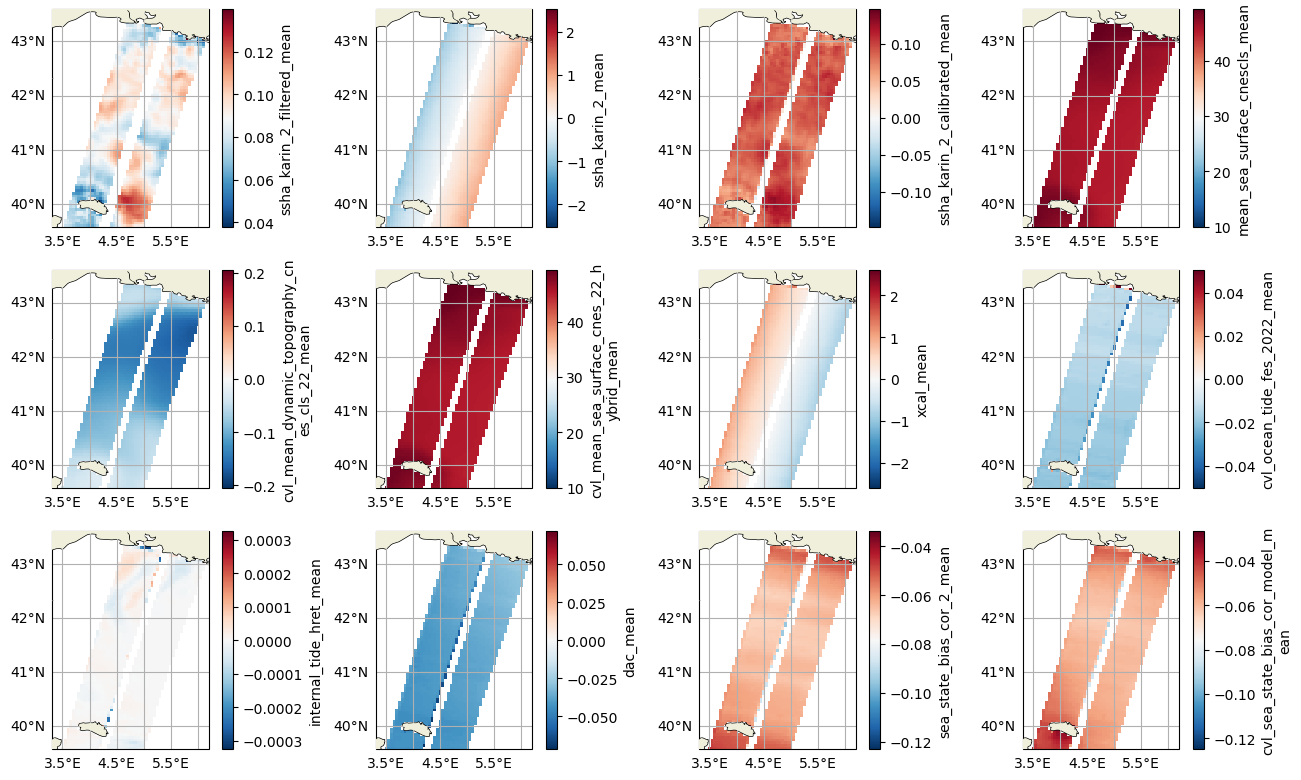

In [51]:
exclude = ["ssha_karin_2_qual", "ssh_karin_uncert"]

ny, nx = 4, 4
fig = plt.figure(figsize=(16,13))

i=1
for v in variables:
    if any([e in v for e in exclude]):
        continue
    ax = fig.add_subplot(ny, nx, i, projection=sd.crs)
    _, _ = sd.plot_map(extent, fig=fig, ax=ax)
    
    #k=labels[v] if v in labels else v
    #print(v, k)
    diags[v+"_mean"].plot(ax=ax, transform=sd.crs, cmap="RdBu_r") #center=True

    i+=1

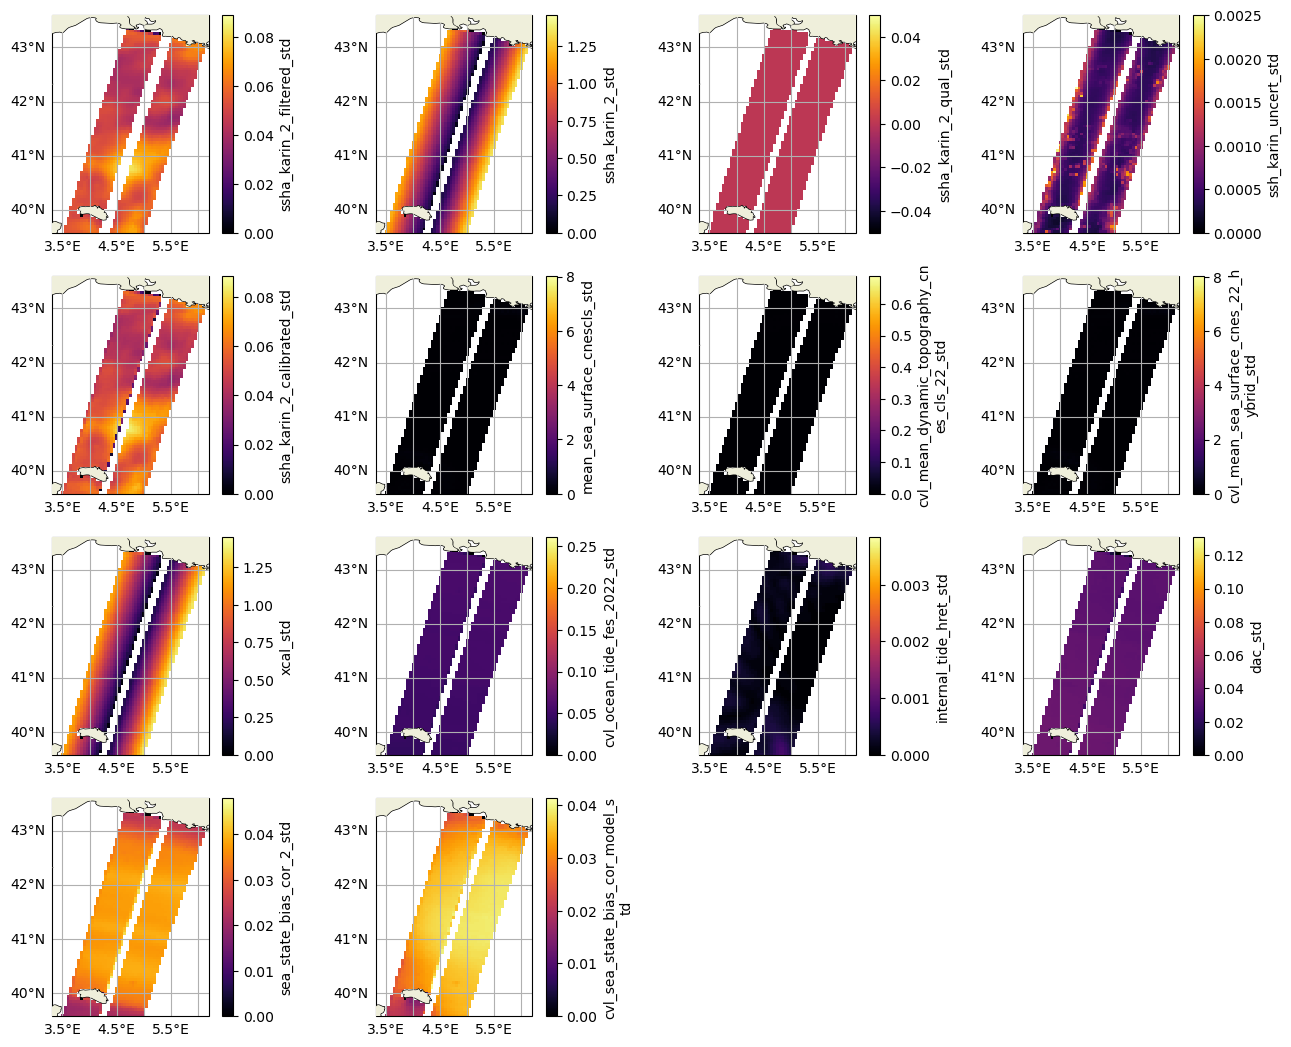

In [53]:
exclude = ["ssha_karin_2_qual",]

ny, nx = 4, 4
fig = plt.figure(figsize=(16,13))

i=1
for v in variables:
    ax = fig.add_subplot(ny, nx, i, projection=sd.crs)
    _, _ = sd.plot_map(info["extent"], fig=fig, ax=ax)
    
    #k=labels[v] if v in labels else v
    #print(v, k)
    diags[v+"_std"].plot(ax=ax, transform=sd.crs, cmap="inferno", center=False)

    i+=1

---

## L2

---

## old

In [38]:
dl=.05
ext = ( 
    np.floor(info["extent"][0]/dl)*dl, 
    np.ceil(info["extent"][1]/dl)*dl,
    np.floor(info["extent"][2]/dl)*dl, 
    np.ceil(info["extent"][3]/dl)*dl,
)

bin2d = swot_calval.statistics.binning2d(
    ds['longitude'].data,
    ds['latitude'].data,
    ds['ssha_karin_2'].data,
    x_axis=swot_calval.statistics.Axis(np.arange(ext[0], ext[1], dl)),
    y_axis=swot_calval.statistics.Axis(np.arange(ext[2], ext[3], dl)),
    simple=True,
    #wgs=pyinterp.geodetic.Spheroid(),
)

In [53]:
print(bin2d)

<pyinterp.binning.Binning2D>
Axis:
  x: <pyinterp.core.Axis>
  min_value: 3.3
  max_value: 6.9
  step     : 0.05
  is_circle: false
  y: <pyinterp.core.Axis>
  min_value: 39.55
  max_value: 43.55
  step     : 0.05
  is_circle: false


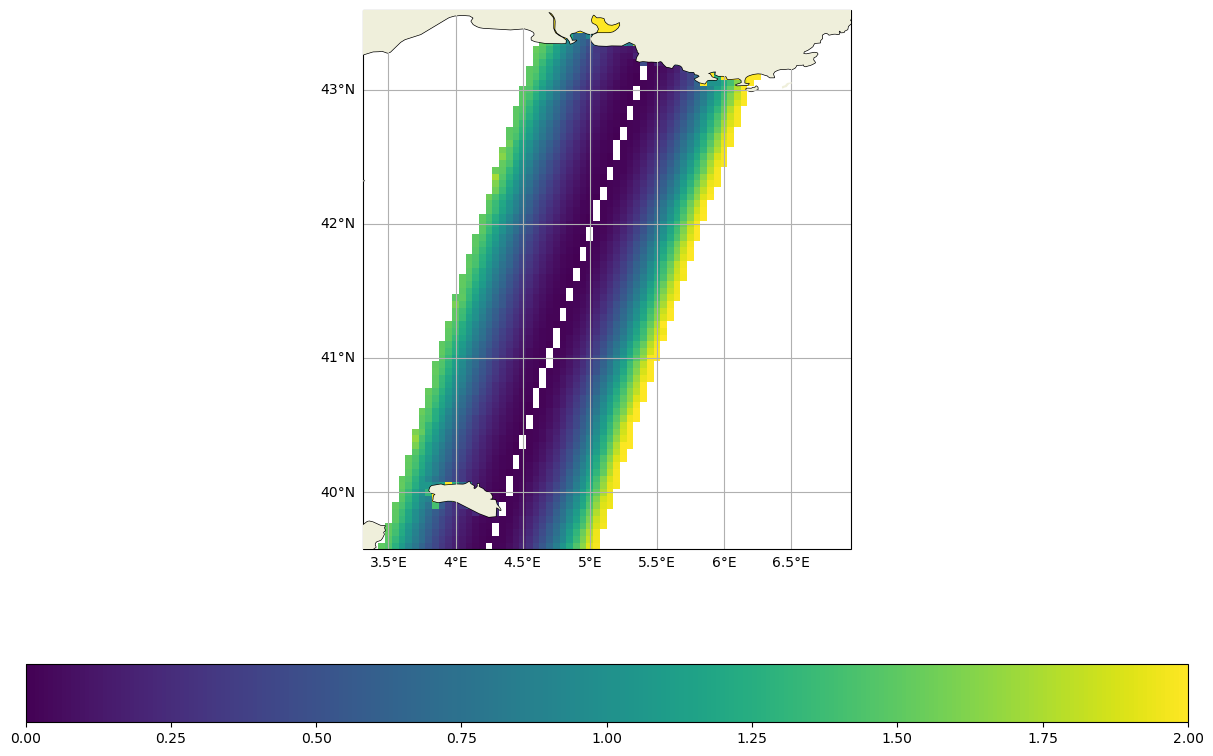

In [63]:
fig, ax = sd.plot_map(info["extent"])
mesh = ax.pcolormesh(
    bin2d.x[:],
    bin2d.y[:],
    bin2d.variable('variance').T,
    transform=cartopy.crs.PlateCarree(),
    shading='auto',
    vmax=2,
)
fig.colorbar(mesh, orientation='horizontal')

In [62]:
 bin2d.variable?

Signature: bin2d.variable(statistics: str = 'mean') -> numpy.ndarray
Docstring:
Gets the regular grid containing the calculated statistics.

Args:
    statistics: The statistics to compute. The following statistics are
        available:

            * ``count`` : compute the count of points within each bin.
            * ``kurtosis`` : compute the kurtosis of values for points
              within each bin.
            * ``max`` : compute the maximum of values for point within
              each bin.
            * ``mean`` : compute the mean of values for points within
              each bin.
            * ``min`` : compute the minimum of values for points within
              each bin.
            * ``skewness`` : compute the skewness within each bin.
            * ``sum`` : compute the sum of values for points within
              each bin.
            * ``sum_of_weights`` : compute the sum of weights within
              each bin.
            * ``variance`` : compute the variance w

In [61]:
swot_calval.statistics.binning2d?

Signature:
swot_calval.statistics.binning2d(
    x: 'Array',
    y: 'Array',
    z: 'Array',
    *,
    x_axis: 'Axis | None' = None,
    y_axis: 'Axis | None' = None,
    dtype: 'numpy.dtype | None' = None,
    simple: 'bool' = False,
    wgs: 'pyinterp.geodetic.Spheroid | None' = None,
    lazy: 'bool' = False,
) -> 'pyinterp.Binning2D | dask.array.core.Array'
Docstring:
Calculate binning of 2D variable.

Args:
    x: X-coordinates of the variable to bin.
    y: Y-coordinates of the variable to bin.
    z: Z-coordinates of the variable to bin.
    x_axis: If provided, use this axis instead of calculating the axis
        from the x-coordinates.
    y_axis: If provided, use this axis instead of calculating the axis
        from the y-coordinates.
    simple: If true, a simple binning 2D is used otherwise a linear
        binning 2d is applied. See the full description of the algorithm
        :external:py:meth:`here <pyinterp.Binning2D.push_delayed>`.
    dtype: Define the data type o

In [26]:
lon = ds['longitude'].compute()
lat = ds['latitude'].compute()
plt.scatter(lon[::10,0], lat[::10,0])

In [ ]:
assert isinstance(bin2d, pyinterp.binning.Binning2D)

In [37]:
swot_calval.statistics.binning2d?

Signature:
swot_calval.statistics.binning2d(
    x: 'Array',
    y: 'Array',
    z: 'Array',
    *,
    x_axis: 'Axis | None' = None,
    y_axis: 'Axis | None' = None,
    dtype: 'numpy.dtype | None' = None,
    simple: 'bool' = False,
    wgs: 'pyinterp.geodetic.Spheroid | None' = None,
    lazy: 'bool' = False,
) -> 'pyinterp.Binning2D | dask.array.core.Array'
Docstring:
Calculate binning of 2D variable.

Args:
    x: X-coordinates of the variable to bin.
    y: Y-coordinates of the variable to bin.
    z: Z-coordinates of the variable to bin.
    x_axis: If provided, use this axis instead of calculating the axis
        from the x-coordinates.
    y_axis: If provided, use this axis instead of calculating the axis
        from the y-coordinates.
    simple: If true, a simple binning 2D is used otherwise a linear
        binning 2d is applied. See the full description of the algorithm
        :external:py:meth:`here <pyinterp.Binning2D.push_delayed>`.
    dtype: Define the data type o